In [1]:
%load_ext autoreload
%autoreload 2

import os, json

import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import animation
from datatools.trace_animator import TraceAnimator
from datatools.trace_helper import TraceHelper
from datatools.visualize_helper import VisualizeHelper
from datatools.nba_helper import NBADataHelper, NBADataAnimator
from datatools.nfl_helper import NFLDataHelper

from models import load_model
from models.utils import print_helper, reshape_tensor, get_dataset_config, normalize_tensor

from models.baselines.graphimputer.graphimputer import BidirectionalGraphImputer

ModuleNotFoundError: No module named 'models.ours.dbhp'

In [7]:
for trial in range(1357, 1364):
    if trial in [1359, 1363]: continue
    device = "cuda:0"
    save_path = f"saved/{trial:03d}"

    with open(f"{save_path}/params.json", "r") as f:
        params = json.load(f)

    if params["model"] == "nrtsi":
        model = load_model(params["model"], params).to(device)

        gap_models_dict = dict()

        gap_models_dict[1] = f"{save_path}/model/nrtsi_state_dict_best_gap_1.pt"
        gap_models_dict[2] = f"{save_path}/model/nrtsi_state_dict_best_gap_2.pt"
        gap_models_dict[4] = f"{save_path}/model/nrtsi_state_dict_best_gap_4.pt"
        gap_models_dict[8] = f"{save_path}/model/nrtsi_state_dict_best_gap_8.pt"
        gap_models_dict[16] = f"{save_path}/model/nrtsi_state_dict_best_gap_16.pt"

        for key in gap_models_dict:
            gap_models_dict[key] = torch.load(gap_models_dict[key], map_location=lambda storage, _: storage)
    else:
        state_dict = torch.load(
            f"{save_path}/model/{params['model']}_state_dict_best.pt",
            map_location=lambda storage, _: storage,
        )

        model = load_model(params["model"], params).to(device)
        model.load_state_dict(state_dict)

    model_name = params["model"]
    dataset = params["dataset"]

    if model_name == "ours":
        physics_loss = params["physics_loss"]
        train_hybrid = params["train_hybrid"]

    statistic_metrics = True
    
    model_keys = ["pred"]
    ret_keys = ["n_frames", "n_missings"]

    if model.params["model"] == "ours":
        if model.params["physics_loss"]:
            model_keys += ["physics_f", "physics_b"]
        if model.params["train_hybrid"]:
            model_keys += ["static_hybrid", "static_hybrid2", "train_hybrid"]
    if statistic_metrics:
        model_keys += ["linear", "knn", "forward"]

        metrics = ["speed", "change_of_step_size", "path_length"]
        ret_keys += [f"{m}_{metric}" for m in model_keys for metric in metrics]

    ret_keys += [f"{m}_dist" for m in model_keys]
    total_ret = {key: 0 for key in ret_keys}

    metrica_files = ["match1.csv", "match2.csv", "match3_valid.csv", "match3_test.csv"]
    metrica_paths = [f"data/metrica_traces/{f}" for f in metrica_files]

    nba_files = os.listdir("data/nba_traces")
    nba_paths = [f"data/nba_traces/{f}" for f in nba_files]
    nba_paths.sort()

    nfl_files = os.listdir("data/nfl_traces")
    nfl_paths = [f"data/nfl_traces/{f}" for f in nfl_files if f.endswith(".csv")]
    nfl_paths.sort()

    if dataset == "soccer":
        trace_helper = TraceHelper
        test_data_paths = metrica_paths[3:4]
    elif dataset == "basketball":
        trace_helper = NBADataHelper
        test_data_paths = nba_paths[90:]
    else: # e.g. "American football"
        trace_helper = NFLDataHelper
        test_data_paths = nfl_paths[0:1]

    print(f"Test data paths : {test_data_paths}")

    for path in test_data_paths:
        print()
        print(path,":")
        match_traces = pd.read_csv(path, header=0, encoding="utf-8-sig")
        helper = trace_helper(traces=match_traces)

        if model_name == "nrtsi":
            ret, df_dict = helper.predict(model, gap_models=gap_models_dict, statistic_metrics=statistic_metrics, dataset=dataset)
        else:
            ret, df_dict = helper.predict(model, statistic_metrics=statistic_metrics, dataset=dataset)

        for key, value in ret.items():
            total_ret[key] += value
            
        print()

    print(f"-Model name : {model_name}")
    print(f"-Dataset : {dataset} | {model.missing_mode}")
    print(f"-Compute statistic_metrics : {statistic_metrics}")
    print("Total Performance:")
    print_helper(total_ret, model_keys, trial=trial, save_txt=True)

    torch.save(helper, f"{save_path}/helper")
    torch.save(df_dict, f"{save_path}/df_dict")
    print("-"*20)            

Test data paths : ['data/metrica_traces/match3_test.csv']

data/metrica_traces/match3_test.csv :


Phase 2:   0%|                                             | 0/10 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
Phase 2:  10%|███▋                                 | 1/10 [00:00<00:06,  1.49it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a t


-Model name : latentode
-Dataset : soccer | player_wise
-Compute statistic_metrics : True
Total Performance:
pred_speed : 4.82789403
pred_change_of_step_size : 0.00167496
pred_path_length : 0.02189702
pred_dist : 19.98768911
linear_speed : 1.25668645
linear_change_of_step_size : 3.874e-05
linear_path_length : 0.01125714
linear_dist : 5.74463912
knn_speed : 3.65244009
knn_change_of_step_size : 0.00060192
knn_path_length : 0.01077581
knn_dist : 7.13127429
forward_speed : 3.48840777
forward_change_of_step_size : 0.00088306
forward_path_length : 0.01125714
forward_dist : 11.20663274
--------------------
Test data paths : ['data/nba_traces/match0021500095.csv', 'data/nba_traces/match0021500096.csv', 'data/nba_traces/match0021500097.csv', 'data/nba_traces/match0021500098.csv', 'data/nba_traces/match0021500099.csv', 'data/nba_traces/match0021500101.csv', 'data/nba_traces/match0021500102.csv', 'data/nba_traces/match0021500103.csv', 'data/nba_traces/match0021500104.csv', 'data/nba_traces/match

Episode:   0%|                                             | 0/65 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon



data/nba_traces/match0021500096.csv :


Episode:   0%|                                             | 0/72 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon



data/nba_traces/match0021500097.csv :


Episode:   0%|                                             | 0/76 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
Episode:   3%|▉                                    | 2/76 [00:00<00:25,  2.93it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a t



data/nba_traces/match0021500098.csv :


Episode:   0%|                                             | 0/64 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
Episode:   2%|▌                                    | 1/64 [00:00<00:42,  1.50it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a t



data/nba_traces/match0021500099.csv :


Episode:   0%|                                             | 0/65 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon



data/nba_traces/match0021500101.csv :


Episode:   0%|                                             | 0/72 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon



data/nba_traces/match0021500102.csv :


Episode:   0%|                                             | 0/71 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon



data/nba_traces/match0021500103.csv :


Episode:   0%|                                             | 0/64 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon



data/nba_traces/match0021500104.csv :


Episode:   0%|                                             | 0/72 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon



data/nba_traces/match0021500105.csv :


Episode:   0%|                                             | 0/73 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
Episode:   4%|█▌                                   | 3/73 [00:00<00:15,  4.56it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a t


-Model name : latentode
-Dataset : basketball | player_wise
-Compute statistic_metrics : True
Total Performance:
pred_speed : 2.02892491
pred_change_of_step_size : 0.00021618
pred_path_length : 0.00401628
pred_dist : 5.09874552
linear_speed : 1.24898804
linear_change_of_step_size : 2.303e-05
linear_path_length : 0.00642
linear_dist : 5.04239984
knn_speed : 2.80588912
knn_change_of_step_size : 0.00023035
knn_path_length : 0.00536822
knn_dist : 5.56630878
forward_speed : 2.61068654
forward_change_of_step_size : 0.00030537
forward_path_length : 0.00642
forward_dist : 7.7805058
--------------------
Test data paths : ['data/nfl_traces/nfl_test.csv']

data/nfl_traces/nfl_test.csv :


Episode:   0%|                                           | 0/1043 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/miniconda3/envs/cy2mixer_env/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
Episode:   0%|                                           | 0/1043 [00:00<?, ?it/s]


RuntimeError: The expanded size of the tensor (18) must match the existing size (36) at non-singleton dimension 1.  Target sizes: [50, 18].  Tensor sizes: [50, 36]

In [8]:
for trial in range(1360, 1363):
    device = "cuda:0"
    save_path = f"saved/{trial:03d}"

    with open(f"{save_path}/params.json", "r") as f:
        params = json.load(f)

    if params["model"] == "nrtsi":
        model = load_model(params["model"], params).to(device)

        gap_models_dict = dict()

        gap_models_dict[1] = f"{save_path}/model/nrtsi_state_dict_best_gap_1.pt"
        gap_models_dict[2] = f"{save_path}/model/nrtsi_state_dict_best_gap_2.pt"
        gap_models_dict[4] = f"{save_path}/model/nrtsi_state_dict_best_gap_4.pt"
        gap_models_dict[8] = f"{save_path}/model/nrtsi_state_dict_best_gap_8.pt"
        gap_models_dict[16] = f"{save_path}/model/nrtsi_state_dict_best_gap_16.pt"

        for key in gap_models_dict:
            gap_models_dict[key] = torch.load(gap_models_dict[key], map_location=lambda storage, _: storage)
    else:
        state_dict = torch.load(
            f"{save_path}/model/{params['model']}_state_dict_best.pt",
            map_location=lambda storage, _: storage,
        )

        model = load_model(params["model"], params).to(device)
        model.load_state_dict(state_dict)

    model_name = params["model"]
    dataset = params["dataset"]

    if model_name == "ours":
        physics_loss = params["physics_loss"]
        train_hybrid = params["train_hybrid"]

    statistic_metrics = True
    
    model_keys = ["pred"]
    ret_keys = ["n_frames", "n_missings"]

    if model.params["model"] == "ours":
        if model.params["physics_loss"]:
            model_keys += ["physics_f", "physics_b"]
        if model.params["train_hybrid"]:
            model_keys += ["static_hybrid", "static_hybrid2", "train_hybrid"]
    if statistic_metrics:
        model_keys += ["linear", "knn", "forward"]

        metrics = ["speed", "change_of_step_size", "path_length"]
        ret_keys += [f"{m}_{metric}" for m in model_keys for metric in metrics]

    ret_keys += [f"{m}_dist" for m in model_keys]
    total_ret = {key: 0 for key in ret_keys}

    metrica_files = ["match1.csv", "match2.csv", "match3_valid.csv", "match3_test.csv"]
    metrica_paths = [f"data/metrica_traces/{f}" for f in metrica_files]

    nba_files = os.listdir("data/nba_traces")
    nba_paths = [f"data/nba_traces/{f}" for f in nba_files]
    nba_paths.sort()

    nfl_files = os.listdir("data/nfl_traces")
    nfl_paths = [f"data/nfl_traces/{f}" for f in nfl_files if f.endswith(".csv")]
    nfl_paths.sort()

    if dataset == "soccer":
        trace_helper = TraceHelper
        test_data_paths = metrica_paths[3:4]
    elif dataset == "basketball":
        trace_helper = NBADataHelper
        test_data_paths = nba_paths[90:]
    else: # e.g. "American football"
        trace_helper = NFLDataHelper
        test_data_paths = nfl_paths[0:1]

    print(f"Test data paths : {test_data_paths}")

    for path in test_data_paths:
        print()
        print(path,":")
        match_traces = pd.read_csv(path, header=0, encoding="utf-8-sig")
        helper = trace_helper(traces=match_traces)

        if model_name == "nrtsi":
            ret, df_dict = helper.predict(model, gap_models=gap_models_dict, statistic_metrics=statistic_metrics, dataset=dataset)
        else:
            ret, df_dict = helper.predict(model, statistic_metrics=statistic_metrics, dataset=dataset)

        for key, value in ret.items():
            total_ret[key] += value
            
        print()

    print(f"-Model name : {model_name}")
    print(f"-Dataset : {dataset} | {model.missing_mode}")
    print(f"-Compute statistic_metrics : {statistic_metrics}")
    print("Total Performance:")
    print_helper(total_ret, model_keys, trial=trial, save_txt=True)

    torch.save(helper, f"{save_path}/helper")
    torch.save(df_dict, f"{save_path}/df_dict")
    print("-"*20)            

Test data paths : ['data/metrica_traces/match3_test.csv']

data/metrica_traces/match3_test.csv :


Phase 2:   0%|                                             | 0/10 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
Phase 2:  10%|███▋                                 | 1/10 [00:00<00:05,  1.55it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a t


-Model name : latentode
-Dataset : soccer | player_wise
-Compute statistic_metrics : True
Total Performance:
pred_speed : 4.82424353
pred_change_of_step_size : 0.00167312
pred_path_length : 0.0218514
pred_dist : 19.93990338
linear_speed : 1.25668645
linear_change_of_step_size : 3.874e-05
linear_path_length : 0.01125714
linear_dist : 5.74463912
knn_speed : 3.65244009
knn_change_of_step_size : 0.00060192
knn_path_length : 0.01077581
knn_dist : 7.13127429
forward_speed : 3.48840777
forward_change_of_step_size : 0.00088306
forward_path_length : 0.01125714
forward_dist : 11.20663274
--------------------
Test data paths : ['data/metrica_traces/match3_test.csv']

data/metrica_traces/match3_test.csv :


Phase 2:   0%|                                             | 0/10 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
Phase 2:  10%|███▋                                 | 1/10 [00:00<00:03,  2.55it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a t

In [10]:
for trial in range(1361, 1363):
    device = "cuda:0"
    save_path = f"saved/{trial:03d}"

    with open(f"{save_path}/params.json", "r") as f:
        params = json.load(f)

    if params["model"] == "nrtsi":
        model = load_model(params["model"], params).to(device)

        gap_models_dict = dict()

        gap_models_dict[1] = f"{save_path}/model/nrtsi_state_dict_best_gap_1.pt"
        gap_models_dict[2] = f"{save_path}/model/nrtsi_state_dict_best_gap_2.pt"
        gap_models_dict[4] = f"{save_path}/model/nrtsi_state_dict_best_gap_4.pt"
        gap_models_dict[8] = f"{save_path}/model/nrtsi_state_dict_best_gap_8.pt"
        gap_models_dict[16] = f"{save_path}/model/nrtsi_state_dict_best_gap_16.pt"

        for key in gap_models_dict:
            gap_models_dict[key] = torch.load(gap_models_dict[key], map_location=lambda storage, _: storage)
    else:
        state_dict = torch.load(
            f"{save_path}/model/{params['model']}_state_dict_best.pt",
            map_location=lambda storage, _: storage,
        )

        model = load_model(params["model"], params).to(device)
        model.load_state_dict(state_dict)

    model_name = params["model"]
    dataset = params["dataset"]

    if model_name == "ours":
        physics_loss = params["physics_loss"]
        train_hybrid = params["train_hybrid"]

    statistic_metrics = True
    
    model_keys = ["pred"]
    ret_keys = ["n_frames", "n_missings"]

    if model.params["model"] == "ours":
        if model.params["physics_loss"]:
            model_keys += ["physics_f", "physics_b"]
        if model.params["train_hybrid"]:
            model_keys += ["static_hybrid", "static_hybrid2", "train_hybrid"]
    if statistic_metrics:
        model_keys += ["linear", "knn", "forward"]

        metrics = ["speed", "change_of_step_size", "path_length"]
        ret_keys += [f"{m}_{metric}" for m in model_keys for metric in metrics]

    ret_keys += [f"{m}_dist" for m in model_keys]
    total_ret = {key: 0 for key in ret_keys}

    metrica_files = ["match1.csv", "match2.csv", "match3_valid.csv", "match3_test.csv"]
    metrica_paths = [f"data/metrica_traces/{f}" for f in metrica_files]

    nba_files = os.listdir("data/nba_traces")
    nba_paths = [f"data/nba_traces/{f}" for f in nba_files]
    nba_paths.sort()

    nfl_files = os.listdir("data/nfl_traces")
    nfl_paths = [f"data/nfl_traces/{f}" for f in nfl_files if f.endswith(".csv")]
    nfl_paths.sort()

    if dataset == "soccer":
        trace_helper = TraceHelper
        test_data_paths = metrica_paths[3:4]
    elif dataset == "basketball":
        trace_helper = NBADataHelper
        test_data_paths = nba_paths[90:]
    else: # e.g. "American football"
        trace_helper = NFLDataHelper
        test_data_paths = nfl_paths[0:1]

    print(f"Test data paths : {test_data_paths}")

    for path in test_data_paths:
        print()
        print(path,":")
        match_traces = pd.read_csv(path, header=0, encoding="utf-8-sig")
        helper = trace_helper(traces=match_traces)

        if model_name == "nrtsi":
            ret, df_dict = helper.predict(model, gap_models=gap_models_dict, statistic_metrics=statistic_metrics, dataset=dataset)
        else:
            ret, df_dict = helper.predict(model, statistic_metrics=statistic_metrics, dataset=dataset)

        for key, value in ret.items():
            total_ret[key] += value
            
        print()

    print(f"-Model name : {model_name}")
    print(f"-Dataset : {dataset} | {model.missing_mode}")
    print(f"-Compute statistic_metrics : {statistic_metrics}")
    print("Total Performance:")
    print_helper(total_ret, model_keys, trial=trial, save_txt=True)

    torch.save(helper, f"{save_path}/helper")
    torch.save(df_dict, f"{save_path}/df_dict")
    print("-"*20)            

Test data paths : ['data/metrica_traces/match3_test.csv']

data/metrica_traces/match3_test.csv :


Phase 2:   0%|                      | 0/10 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
Phase 2:  10%|█▍            | 1/10 [00:00<00:05,  1.54it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c


-Model name : latentode
-Dataset : soccer | all_player
-Compute statistic_metrics : True
Total Performance:
pred_speed : 5.99189161
pred_change_of_step_size : 0.00246726
pred_path_length : 0.03410482
pred_dist : 20.52146694
linear_speed : 1.13373598
linear_change_of_step_size : 3.728e-05
linear_path_length : 0.00994627
linear_dist : 4.67500968
knn_speed : 4.24093416
knn_change_of_step_size : 0.00115518
knn_path_length : 0.01290836
knn_dist : 10.32223528
forward_speed : 3.74402368
forward_change_of_step_size : 0.00110107
forward_path_length : 0.00994627
forward_dist : 10.06583871
--------------------
Test data paths : ['data/nba_traces/match0021500095.csv', 'data/nba_traces/match0021500096.csv', 'data/nba_traces/match0021500097.csv', 'data/nba_traces/match0021500098.csv', 'data/nba_traces/match0021500099.csv', 'data/nba_traces/match0021500101.csv', 'data/nba_traces/match0021500102.csv', 'data/nba_traces/match0021500103.csv', 'data/nba_traces/match0021500104.csv', 'data/nba_traces/match

Episode:   0%|                      | 0/65 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g



data/nba_traces/match0021500096.csv :


Episode:   0%|                      | 0/72 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g



data/nba_traces/match0021500097.csv :


Episode:   0%|                      | 0/76 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
Episode:   3%|▎             | 2/76 [00:00<00:24,  3.03it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c



data/nba_traces/match0021500098.csv :


Episode:   0%|                      | 0/64 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
Episode:   2%|▏             | 1/64 [00:00<00:41,  1.52it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c



data/nba_traces/match0021500099.csv :


Episode:   0%|                      | 0/65 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g



data/nba_traces/match0021500101.csv :


Episode:   0%|                      | 0/72 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g



data/nba_traces/match0021500102.csv :


Episode:   0%|                      | 0/71 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g



data/nba_traces/match0021500103.csv :


Episode:   0%|                      | 0/64 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g



data/nba_traces/match0021500104.csv :


Episode:   0%|                      | 0/72 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g



data/nba_traces/match0021500105.csv :


Episode:   0%|                      | 0/73 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
Episode:   4%|▌             | 3/73 [00:00<00:15,  4.57it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c


-Model name : latentode
-Dataset : basketball | all_player
-Compute statistic_metrics : True
Total Performance:
pred_speed : 2.30376912
pred_change_of_step_size : 0.00030698
pred_path_length : 0.00424143
pred_dist : 5.71976721
linear_speed : 1.15886676
linear_change_of_step_size : 2.021e-05
linear_path_length : 0.00573541
linear_dist : 4.13439601
knn_speed : 3.0950726
knn_change_of_step_size : 0.00039716
knn_path_length : 0.00634247
knn_dist : 7.70675311
forward_speed : 2.6943835
forward_change_of_step_size : 0.00035481
forward_path_length : 0.00573541
forward_dist : 6.67439177
--------------------


In [9]:
save_path

'saved/1363'

In [64]:
# 1357 - soccer / camera_simulate
# 1358 - basketball / player_wise
# 1359 - football / player_wise
# 1360 - soccer / player_wise
# 1361 - soccer / all_player
# 1362 - basketball / all_player
# 1363 - football / all_player

device = "cuda:0"
trial = 1359
save_path = f"saved/{trial:03d}"

with open(f"{save_path}/params.json", "r") as f:
    params = json.load(f)

if params["model"] == "nrtsi":
    model = load_model(params["model"], params).to(device)

    gap_models_dict = dict()

    gap_models_dict[1] = f"{save_path}/model/nrtsi_state_dict_best_gap_1.pt"
    gap_models_dict[2] = f"{save_path}/model/nrtsi_state_dict_best_gap_2.pt"
    gap_models_dict[4] = f"{save_path}/model/nrtsi_state_dict_best_gap_4.pt"
    gap_models_dict[8] = f"{save_path}/model/nrtsi_state_dict_best_gap_8.pt"
    gap_models_dict[16] = f"{save_path}/model/nrtsi_state_dict_best_gap_16.pt"

    for key in gap_models_dict:
        gap_models_dict[key] = torch.load(gap_models_dict[key], map_location=lambda storage, _: storage)
else:
    state_dict = torch.load(
        f"{save_path}/model/{params['model']}_state_dict_best.pt",
        map_location=lambda storage, _: storage,
    )

    model = load_model(params["model"], params).to(device)
    model.load_state_dict(state_dict)

In [65]:
model_name = params["model"]
dataset = params["dataset"]

if model_name == "ours":
    physics_loss = params["physics_loss"]
    train_hybrid = params["train_hybrid"]

statistic_metrics = True

print(f"-Model name : {model_name}")
print(f"-Dataset : {dataset}")
print(f"-Compute statistic_metrics : {statistic_metrics}")

-Model name : latentode
-Dataset : football
-Compute statistic_metrics : True


In [66]:
model_keys = ["pred"]
ret_keys = ["n_frames", "n_missings"]

if model.params["model"] == "ours":
    if model.params["physics_loss"]:
        model_keys += ["physics_f", "physics_b"]
    if model.params["train_hybrid"]:
        model_keys += ["static_hybrid", "static_hybrid2", "train_hybrid"]
if statistic_metrics:
    model_keys += ["linear", "knn", "forward"]

    metrics = ["speed", "change_of_step_size", "path_length"]
    ret_keys += [f"{m}_{metric}" for m in model_keys for metric in metrics]

ret_keys += [f"{m}_dist" for m in model_keys]
total_ret = {key: 0 for key in ret_keys}

In [67]:
metrica_files = ["match1.csv", "match2.csv", "match3_valid.csv", "match3_test.csv"]
metrica_paths = [f"data/metrica_traces/{f}" for f in metrica_files]

nba_files = os.listdir("data/nba_traces")
nba_paths = [f"data/nba_traces/{f}" for f in nba_files]
nba_paths.sort()

nfl_files = os.listdir("data/nfl_traces")
nfl_paths = [f"data/nfl_traces/{f}" for f in nfl_files if f.endswith(".csv")]
nfl_paths.sort()

if dataset == "soccer":
    trace_helper = TraceHelper
    test_data_paths = metrica_paths[3:4]
elif dataset == "basketball":
    trace_helper = NBADataHelper
    test_data_paths = nba_paths[90:]
else: # e.g. "American football"
    trace_helper = NFLDataHelper
    test_data_paths = nfl_paths[0:1]

print(f"Test data paths : {test_data_paths}")

Test data paths : ['data/nfl_traces/nfl_test.csv']


### Run model

In [62]:
model.params['n_players'] = 6
for path in test_data_paths:
    print()
    print(path,":")
    match_traces = pd.read_csv(path, header=0, encoding="utf-8-sig")
    helper = trace_helper(traces=match_traces)

    if model_name == "nrtsi":
        ret, df_dict = helper.predict(model, gap_models=gap_models_dict, statistic_metrics=statistic_metrics, dataset=dataset)
    else:
        ret, df_dict = helper.predict(model, statistic_metrics=statistic_metrics, dataset=dataset)

    for key, value in ret.items():
        total_ret[key] += value
        
    print()

print("Total Performance:")
print_helper(total_ret, model_keys, trial=trial, save_txt=True)

torch.save(helper, f"{save_path}/helper")
torch.save(df_dict, f"{save_path}/df_dict")


data/nfl_traces/nfl_test.csv :


Episode:   0%|                                           | 0/1043 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/miniconda3/envs/cy2mixer_env/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
Episode:   0%|                                   | 1/1043 [00:00<04:42,  3.69it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().


Total Performance:
pred_speed : 8.33916189
pred_change_of_step_size : 0.0065213
pred_path_length : 0.15568775
pred_dist : 3.04075791
linear_speed : 0.69692083
linear_change_of_step_size : 0.00017201
linear_path_length : 0.0025719
linear_dist : 0.57425564
knn_speed : 11.16348603
knn_change_of_step_size : 0.00848809
knn_path_length : 0.15337002
knn_dist : 3.82858358
forward_speed : 5.04574218
forward_change_of_step_size : 0.00486407
forward_path_length : 0.0025719
forward_dist : 1.90856849


PicklingError: Can't pickle <class 'datatools.nfl_helper.NFLDataHelper'>: it's not the same object as datatools.nfl_helper.NFLDataHelper

In [69]:
model.params['missing_mode']

KeyError: 'missing_mode'

In [68]:
model.params['n_players'] = 6
for path in test_data_paths:
    print()
    print(path,":")
    match_traces = pd.read_csv(path, header=0, encoding="utf-8-sig")
    helper = trace_helper(traces=match_traces)

    if model_name == "nrtsi":
        ret, df_dict = helper.predict(model, gap_models=gap_models_dict, statistic_metrics=statistic_metrics, dataset=dataset)
    else:
        ret, df_dict = helper.predict(model, statistic_metrics=statistic_metrics, dataset=dataset)

    for key, value in ret.items():
        total_ret[key] += value
        
    print()

print("Total Performance:")
print_helper(total_ret, model_keys, trial=trial, save_txt=True)

torch.save(helper, f"{save_path}/helper")
torch.save(df_dict, f"{save_path}/df_dict")


data/nfl_traces/nfl_test.csv :


Episode:   0%|                                           | 0/1043 [00:00<?, ?it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_gap = torch.tensor(time_gap, dtype = torch.float32).unsqueeze(0)
/shared/home/mhlee7227/miniconda3/envs/cy2mixer_env/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
Episode:   0%|                                   | 1/1043 [00:00<04:02,  4.29it/s]/shared/home/mhlee7227/hybrid-imputation/models/baselines/latentode/latent_ode.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().


Total Performance:
pred_speed : 3.61838452
pred_change_of_step_size : 0.00218577
pred_path_length : 0.01911773
pred_dist : 3.2609998
linear_speed : 1.46628653
linear_change_of_step_size : 0.00031336
linear_path_length : 0.00341919
linear_dist : 1.7380983
knn_speed : 4.43577033
knn_change_of_step_size : 0.00226803
knn_path_length : 0.01480408
knn_dist : 2.39539349
forward_speed : 5.25356922
forward_change_of_step_size : 0.00424834
forward_path_length : 0.00341919
forward_dist : 3.82204289


PicklingError: Can't pickle <class 'datatools.nfl_helper.NFLDataHelper'>: it's not the same object as datatools.nfl_helper.NFLDataHelper

## Performance analysis

##### (1) Get Main model results

In [18]:
trial = 1362
save_path = f"saved/{trial:03d}"
if os.path.isfile(save_path + "/df_dict"):
    helper =  torch.load(save_path + "/helper")
    df_dict = torch.load(save_path + "/df_dict")
    with open(f"{save_path}/params.json", "r") as f:
        params = json.load(f)

##### (2) Add baseline model results

In [19]:
# trial_dict = {4000 : "brits", 5000 : "naomi", 214 : "nrtsi"} # Metrica
trial_dict = {4003 : "brits", 5001 : "naomi", 6001 : "nrtsi", 9996 : "graphimputer"} # NBA
for (t, model_name) in trial_dict.items():
    save_path = f"saved/{t:03d}"
    if os.path.isfile(save_path + "/df_dict"):
        df_dict_ = torch.load(save_path + "/df_dict")
        df_dict[f"{model_name}_df"] = df_dict_["pred_df"]

In [21]:
df_dict.keys()

dict_keys(['target_df', 'mask_df', 'pred_df', 'linear_df', 'knn_df', 'forward_df'])

### Animation

##### (1) Soccer Animator

In [10]:
helper.traces["episode"].unique()

array([  1,   2,   0,   4,   6,   8,  16,  18,  20,  22,  24,  26,  28,
        30,  32,  36,  38,  41,  43,  44,  46,  48,  51,  53,  54,  55,
        57,  58,  62,  63,  64,  66,  68,  70,  76,  80,  83,  85,  86,
        88,  90,  92,  94,  95,  96,  97,  99, 101, 103, 105, 107, 111,
       112, 114, 118, 120, 121, 123, 124, 126, 127, 129, 131, 133, 136,
       138, 140, 142, 144, 145, 146, 148, 152, 154])

In [ ]:
i0 = 479
i1 = 873

animator = TraceAnimator(
    trace_dict={"main": df_dict["target_df"][i0:i1], "pred": df_dict["train_hybrid_df"][i0:i1]},
    mask = df_dict["mask_df"][i0:i1],
    show_episodes=True,
    show_events=False,
    show_frames=False,
    show_polygon=True,
    annot_cols=None,
)
anim = animator.run()

path = f"animations/trial_{trial}.mp4"

writer = animation.FFMpegWriter(fps=10)
anim.save(path, writer=writer)

##### (2) Basketball Animator

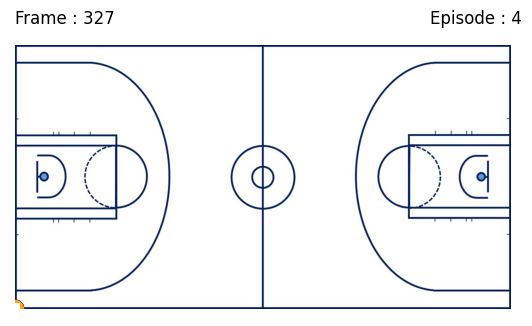

FileNotFoundError: [Errno 2] No such file or directory: 'animations'

In [27]:
i0 = 326
i1 = 737
animator = NBADataAnimator(
    # trace_dict={"main": df_dict["target_df"][i0:i1], "pred": df_dict["train_hybrid_df"][i0:i1]},
    trace_dict={"main": df_dict["target_df"][i0:i1], "pred": df_dict["pred_df"][i0:i1]},
    show_episodes=True,
    show_frames=True,
    masks = df_dict["mask_df"][i0:i1],
)
anim = animator.run()

path = f"animations/trial_{trial}.mp4"

writer = animation.FFMpegWriter(fps=10)
anim.save(path, writer=writer)

### plotting

In [35]:
plot_mode = "imputed_traj" # "imputed_traj", "dist_heatmap", "weights_heatmap"
dataset = params["dataset"]
visualizer = VisualizeHelper(trial, df_dict, plot_mode, dataset=dataset, helper=helper)
visualizer.valid_episodes()

Valid episode idxs : [4, 6, 8, 16, 20, 22, 24, 26, 28, 30, 32, 36, 38, 41, 44, 48, 53, 54, 55, 57, 58, 62, 63, 64, 66, 70, 83, 85, 88, 94, 96, 99, 103, 111, 114, 118, 123, 124, 126, 127, 131, 136, 138, 140, 142, 144, 145, 154]


In [34]:
visualizer.df_dict.keys()

dict_keys(['target_df', 'mask_df', 'pred_df', 'linear_df', 'knn_df', 'forward_df'])

In [36]:
visualizer.plot_run(epi_idx=0)
plt.close()

Plotting episode : 4
Plot Mode : imputed_traj
Saved path : plots/basketball/1362/imputed_traj/episode_4
